# 1.Import

In [122]:
import gc
import os
import json
from PIL import Image
import numpy as np
import tensorflow as tf
from transformers import AutoImageProcessor, AutoModel, TFAutoModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TFGPT2LMHeadModel
import torch
from torch import nn
import random
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from heapq import heappush, heappop

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用第0块GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 2.Backbone

In [3]:
# 初始化模型
# 加载 ViT TensorFlow 版本的 backbone
# backbone = TFAutoModel.from_pretrained('google/vit-base-patch16-224-in21k')
# processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# 保存模型到本地 
# backbone.save_pretrained("./vit-base-patch16-224-in21k_model") 
# processor.save_pretrained("./vit-base-patch16-224-in21k_processor")

# 从本地加载模型    Загрузка модели локально
backbone = TFAutoModel.from_pretrained('./vit-base-patch16-224-in21k_model')
processor = AutoImageProcessor.from_pretrained('./vit-base-patch16-224-in21k_processor')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at ./vit-base-patch16-224-in21k_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [4]:
# 加载 GPT-2 模型
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# text_model = TFGPT2LMHeadModel.from_pretrained("gpt2")

# 保存 GPT-2 模型
# tokenizer.save_pretrained("./gpt2_tokenizer")
# text_model.save_pretrained("./gpt2_text_model")

# 从本地加载 GPT-2 模型
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2_tokenizer")
text_model = TFGPT2LMHeadModel.from_pretrained("./gpt2_text_model")

# 添加特殊标记，包括起始、结束和填充标记    Добавление специальных токенов: начало, конец и заполнение
tokenizer.add_special_tokens({
    "bos_token": "<BOS>",  # 起始标记
    "eos_token": "<EOS>",  # 结束标记
    "pad_token": "<PAD>"   # 填充标记
})

# 设置特殊标记的 token_id
tokenizer.bos_token_id = 50254
tokenizer.eos_token_id = 50255
tokenizer.pad_token_id = 50256

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [79]:
print(tokenizer.bos_token_id,
tokenizer.eos_token_id,
tokenizer.pad_token_id)

50254 50255 50256


# 3.Data

In [6]:
# 数据路径    Путь к данным
image_dir = "C:/Users/lcf14/Desktop/homework/Machine_Learning_appli/train2017"  # 图像目录    Каталог изображений
annotation_path = "C:/Users/lcf14/Desktop/homework/Machine_Learning_appli/annotations_trainval2017/annotations/captions_train2017.json"  # 注释文件路径    Путь к файлу аннотаций

In [7]:
# 加载 COCO captions 标注    Загрузка аннотаций COCO captions
with open(annotation_path, 'r') as f:  # 打开注释文件    Открытие файла аннотаций
    coco_data = json.load(f)  # 加载 JSON 数据    Загрузка данных JSON

In [8]:
# 构建 file_name 到 image_id 的映射，以及 image_id 到 captions 的映射    Создание отображения file_name на image_id и image_id на captions
file_name_to_id = {image["file_name"]: image["id"] for image in coco_data["images"]}  # 文件名到图像ID的映射    Отображение имени файла на ID изображения
image_id_to_captions = {}  # 图像ID到标题的映射    Отображение ID изображения на подписи
for annotation in coco_data["annotations"]:  # 遍历所有注释    Перебор всех аннотаций
    img_id = annotation["image_id"]  # 获取图像ID    Получение ID изображения
    caption = annotation["caption"]  # 获取标题    Получение подписи
    if img_id not in image_id_to_captions:  # 如果图像ID不在字典中，则添加    Если ID изображения нет в словаре, добавить
        image_id_to_captions[img_id] = []  # 初始化标题列表    Инициализация списка подписей
    image_id_to_captions[img_id].append(caption)  # 将标题添加到列表中    Добавление подписи в список

Image ID: 409227, Captions: ['Three zebra are eating hay in an enclosed area. ', 'Several zebra standing together with their heads down, inside an enclosed and gated area.', 'These three zebras graze quietly at the zoo ', 'Three zebras eating from a bale in an outdoor pen', 'A couple of zebras that are eating some hay. ']


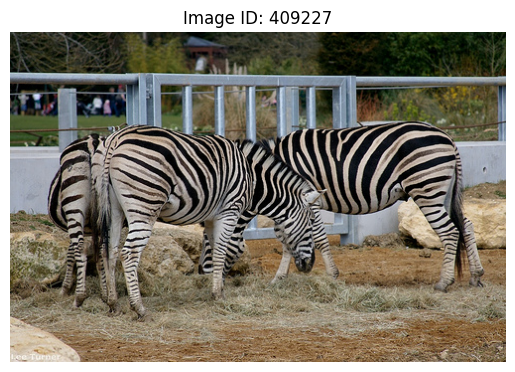

Image ID: 375820, Captions: ['two laptops showing information and placed on atable', 'Two computers light up a room that is dark. ', 'Two monitors that are on, on a desk in the dark ', 'A dual monitor set up in a room.', 'Two computer monitors displaying web pages in a dark room.']


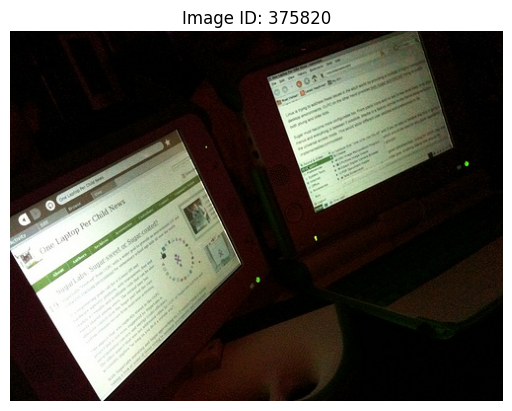

Image ID: 435433, Captions: ['A dog wearing a coat hugging a large black dog.', 'A large dog being hugged by a smaller dog on a leash.', 'a black dog and a brown and black dog with a jacket', 'A small dog is hugging a larger black dog.', 'Here are is a stuffed toy dog and its beloved owner dressed in an animal costume']


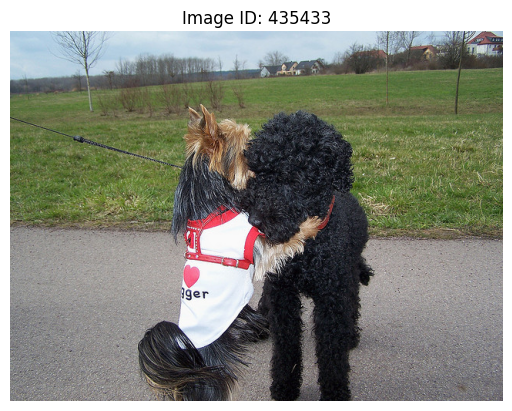

In [9]:
# 随机选择三个 image_id    Случайный выбор трех image_id
random_image_ids = random.sample(list(image_id_to_captions.keys()), 3)

for key in random_image_ids:
    value = image_id_to_captions[key]
    print(f"Image ID: {key}, Captions: {value}")

    # 查找对应的文件名    Поиск соответствующего имени файла
    file_name = None
    for name, id in file_name_to_id.items():
        if id == key:
            file_name = name
            break

    # 加载和显示图片    Загрузка и отображение изображения
    if file_name:
        image_path = os.path.join(image_dir, file_name)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f"Image ID: {key}")
        plt.axis('off')  # 隐藏坐标轴    Скрыть оси координат
        plt.show()

# 4.Feature extraction

In [10]:
# 提取特征并保存    Извлечение и сохранение признаков
def extract_features(image_path):  # 定义提取特征的函数    Определение функции извлечения признаков
    try:
        image = Image.open(image_path).convert("RGB")  # 打开图像并转换为RGB格式    Открытие изображения и преобразование в формат RGB
        inputs = processor(images=image, return_tensors="tf")  # TensorFlow 格式输入    Входные данные в формате TensorFlow
        outputs = backbone(**inputs)  # 获取模型输出    Получение выходных данных модели
        
        # 使用 TensorFlow 的 tf.squeeze 去除维度为1的维度    Использование tf.squeeze для удаления размерности 1 в TensorFlow
        features = tf.squeeze(outputs.last_hidden_state, axis=0).numpy()  # 移除批次维度    Удаление размерности пакета
    except Exception as e:  # 捕获异常    Обработка исключений
        print(f"Error processing image {image_path}: {e}")  # 打印错误信息    Вывод сообщения об ошибке
        features = None  # 设置特征为 None    Установка признаков в None
    finally:
        # 显式释放内存    Явное освобождение памяти
        del image, inputs, outputs  # 删除变量    Удаление переменных
        gc.collect()  # 进行垃圾回收    Сборка мусора
    
    return features  # 返回提取的特征    Возвращение извлеченных признаков

In [11]:
# 限制加载图像数量
N = 30000  # 仅加载前 N 张图像，调试时可调整    Загружать только первые N изображений, можно изменить для отладки
image_paths = sorted(os.listdir(image_dir))[:N]  # 获取排序后的图像路径列表，仅保留前 N 个    Получить отсортированный список путей к изображениям, оставить только первые N

In [11]:
# 初始化特征字典    Инициализация словаря признаков
features = {}  # 空字典，用于存储图像特征    Пустой словарь для хранения признаков изображений

# 遍历图像路径列表    Перебор списка путей к изображениям
for img_name in tqdm(image_paths):  # 使用 tqdm 显示进度条    Использование tqdm для отображения индикатора прогресса
    img_path = os.path.join(image_dir, img_name)  # 构建图像文件的完整路径    Построение полного пути к файлу изображения
    if os.path.exists(img_path):  # 检查图像文件是否存在    Проверка существования файла изображения
        features[img_name] = extract_features(img_path)  # 提取图像特征并存储在字典中    Извлечение признаков изображения и сохранение в словаре
        # 定期垃圾回收（每处理100张触发）    Регулярная сборка мусора (срабатывает каждые 100 изображений)
        if len(features) % 100 == 0:  # 检查是否处理了100张图像    Проверка, обработано ли 100 изображений
            gc.collect()  # 进行垃圾回收    Выполнение сборки мусора
            torch.cuda.empty_cache()  # 清空 CUDA 缓存    Очистка кэша CUDA

 82%|█████████████████████████████████████████████████████████             | 96422/118287 [27:34:10<6:15:06,  1.03s/it]


Error processing image C:/Users/lcf14/Desktop/homework/Machine_Learning_appli/train2017\000000474245.jpg: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64


UnboundLocalError: cannot access local variable 'inputs' where it is not associated with a value

In [12]:
# 保存特征以便后续加载    Сохранение признаков для последующей загрузки
#np.save("image_features_vit.npy", features)  # 保存特征到文件    Сохранение признаков в файл

# 加载已保存的调试特征    Загрузка сохраненных признаков для отладки
features = np.load("image_features_vit.npy", allow_pickle=True).item()  # 从文件加载特征    Загрузка признаков из файла

In [13]:
# 检查提取特征的形状和内容    Проверка формы и содержания извлеченных признаков
def check_features(features):  # 定义检查特征的函数    Определение функции проверки признаков
    non_empty_features = {k: v for k, v in features.items() if v is not None}  # 非空特征字典    Словарь непустых признаков
    empty_features = {k: v for k, v in features.items() if v is None}  # 空特征字典    Словарь пустых признаков
    
    print(f"Total features processed: {len(features)}")  # 打印处理的总特征数    Вывод общего количества обработанных признаков
    print(f"Non-empty features: {len(non_empty_features)}")  # 打印非空特征数    Вывод количества непустых признаков
    print(f"Empty features: {len(empty_features)}")  # 打印空特征数    Вывод количества пустых признаков
    
    if len(non_empty_features) > 0:  # 如果有非空特征    Если есть непустые признаки
        # 打印部分非空特征的形状和样例数据    Вывод формы и примеров данных некоторых непустых признаков
        for i, (file_name, feature) in enumerate(non_empty_features.items()):  # 遍历非空特征    Перебор непустых признаков
            print(f"Feature for {file_name}: Shape = {feature.shape}")  # 打印特征形状    Вывод формы признака
            print(f"Sample feature data (first 5 values): {feature.flatten()[:5]}")  # 打印特征的前5个值    Вывод первых 5 значений признака
            if i >= 2:  # 打印最多3个    Вывод не более 3 признаков
                break

    if len(empty_features) > 0:  # 如果有空特征    Если есть пустые признаки
        # 打印失败的图片文件名    Вывод имен файлов неудачных изображений
        print("Failed images:")  # 打印失败的图片标题    Вывод заголовка неудачных изображений
        for file_name in empty_features.keys():  # 遍历空特征    Перебор пустых признаков
            print(f" - {file_name}")  # 打印文件名    Вывод имени файла

In [14]:
# 检查提取特征的形状和内容    Проверка формы и содержания извлеченных признаков
check_features(features)

Total features processed: 30000
Non-empty features: 30000
Empty features: 0
Feature for 000000000009.jpg: Shape = (197, 768)
Sample feature data (first 5 values): [ 0.20210068 -0.14539985  0.31765735  0.02103074 -0.02074533]
Feature for 000000000025.jpg: Shape = (197, 768)
Sample feature data (first 5 values): [-0.02263155 -0.11529901  0.04397036  0.08367317 -0.08488812]
Feature for 000000000030.jpg: Shape = (197, 768)
Sample feature data (first 5 values): [-0.3291963  -0.16350386  0.0211654  -0.30505317  0.00742803]


In [108]:
gc.collect()
torch.cuda.empty_cache()

# 5.Dataset

In [16]:
class CocoCaptioningDataLoader(tf.keras.utils.Sequence):  # 定义CocoCaptioningDataLoader类，继承自tf.keras.utils.Sequence    Определение класса CocoCaptioningDataLoader, наследующего tf.keras.utils.Sequence
    def __init__(self, image_dir, features, tokenizer, batch_size, max_len, file_name_to_id, image_id_to_captions, **kwargs):  # 初始化方法    Метод инициализации
        super().__init__(**kwargs)  # 调用父类的初始化方法    Вызов метода инициализации родительского класса
        self.image_dir = image_dir  # 图像目录    Каталог изображений
        self.features = features  # 提取的特征字典    Словарь извлеченных признаков
        self.tokenizer = tokenizer  # 分词器    Токенизатор
        self.batch_size = batch_size  # 批次大小    Размер пакета
        self.max_len = max_len  # 最大长度    Максимальная длина

        # 使用传入的映射    Использование переданных отображений
        self.file_name_to_id = file_name_to_id  # 文件名到图像ID的映射    Отображение имени файла на ID изображения
        self.image_id_to_captions = image_id_to_captions  # 图像ID到标题的映射    Отображение ID изображения на подписи

        # 根据特征字典过滤图像路径，确保一致性    Фильтрация путей к изображениям на основе словаря признаков для обеспечения согласованности
        self._filter_image_paths()

    def _filter_image_paths(self):  # 根据特征字典过滤有效图像路径    Фильтрация допустимых путей к изображениям на основе словаря признаков
        print("Filtering image paths based on features...")  # 打印过滤信息    Вывод информации о фильтрации
        feature_image_names = set(self.features.keys())  # 特征中的图片文件名集合    Множество имен файлов изображений в признаках
        all_image_files = set(os.listdir(self.image_dir))  # 本地图片文件名集合    Множество имен файлов изображений в локальном каталоге
        valid_image_names = feature_image_names & all_image_files  # 交集    Пересечение множеств

        # 构建有效图像路径    Построение допустимых путей к изображениям
        self.image_paths = [os.path.join(self.image_dir, image_name) for image_name in valid_image_names]

        # 过滤无效的 image_id 到 captions 的映射    Фильтрация недопустимых отображений image_id на подписи
        valid_image_ids = {self.file_name_to_id[image_name] for image_name in valid_image_names if image_name in self.file_name_to_id}
        self.image_id_to_captions = {img_id: captions for img_id, captions in self.image_id_to_captions.items() if img_id in valid_image_ids}

        print(f"Total valid images: {len(self.image_paths)}")  # 打印有效图像的总数    Вывод общего количества допустимых изображений

    def random_seq(self, image_path):  # 从每张图片的标题列表中随机选择一个    Случайный выбор одного из заголовков для каждого изображения
        image_file_name = os.path.basename(image_path)  # 获取图片文件名    Получение имени файла изображения
        image_id = self.file_name_to_id[image_file_name]  # 获取图像ID    Получение ID изображения
        captions = self.image_id_to_captions[image_id]  # 获取标题列表    Получение списка заголовков
        return random.choice(captions)  # 随机选择一个标题    Случайный выбор одного заголовка

    def __len__(self):  # 返回数据集的总批次数    Возвращение общего количества пакетов в наборе данных
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def _process_caption(self, caption):  # 处理标题：编码、截断、添加特殊标记和填充    Обработка заголовка: кодирование, обрезка, добавление специальных токенов и заполнение
        caption_tokens = self.tokenizer.encode(caption)  # 编码标题    Кодирование заголовка
        caption_tokens = caption_tokens[:self.max_len - 2]  # 截断标题以适应最大长度    Обрезка заголовка до максимальной длины
        caption_tokens = [self.tokenizer.bos_token_id] + caption_tokens + [self.tokenizer.eos_token_id]  # 添加起始和结束标记    Добавление начального и конечного токенов
        caption_tokens += [self.tokenizer.pad_token_id] * (self.max_len - len(caption_tokens))  # 填充标题    Заполнение заголовка
        return caption_tokens

    def __getitem__(self, idx):  # 获取当前batch的图像路径    Получение путей к изображениям текущего пакета
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        # 初始化输入和输出数组    Инициализация массивов входных и выходных данных
        batch_features = []
        batch_captions = []

        for image_path in batch_image_paths:
            image_file_name = os.path.basename(image_path)  # 获取图片文件名    Получение имени файла изображения
            feature = self.features.get(image_file_name, None)  # 获取图像特征    Получение признаков изображения
            if feature is not None:
                batch_features.append(feature)

                # 随机选择标题并编码    Случайный выбор заголовка и его кодирование
                caption = self.random_seq(image_path)
                caption_tokens = self._process_caption(caption)
                batch_captions.append(caption_tokens)

        # 确保维度正确    Обеспечение правильных размерностей
        batch_features = np.array(batch_features).reshape(-1, 197, 768)
        batch_features = tf.convert_to_tensor(batch_features, dtype=tf.float64)
        batch_captions = tf.convert_to_tensor(np.array(batch_captions), dtype=tf.int64)

        return (batch_features, batch_captions), batch_captions

    def on_epoch_end(self):  # 每个epoch结束时调用，进行数据洗牌    Вызов в конце каждой эпохи для перемешивания данных
        random.shuffle(self.image_paths)


In [17]:
# 加载图像路径    Загрузка путей к изображениям
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir))]  # 获取排序后的图像路径列表    Получение отсортированного списка путей к изображениям
batch_size = 128  # 批次大小    Размер пакета
max_len = 50  # 最大长度    Максимальная длина

# 创建数据加载器    Создание загрузчика данных
train_loader = CocoCaptioningDataLoader(
    image_dir=image_dir,  # 图像目录    Каталог изображений
    features=features,  # 提取的特征字典    Словарь извлеченных признаков
    tokenizer=tokenizer,  # 分词器    Токенизатор
    batch_size=batch_size,  # 批次大小    Размер пакета
    max_len=max_len,  # 最大长度    Максимальная длина
    file_name_to_id=file_name_to_id,  # 文件名到图像ID的映射    Отображение имени файла на ID изображения
    image_id_to_captions=image_id_to_captions  # 图像ID到标题的映射    Отображение ID изображения на подписи
)

Filtering image paths based on features...
Total valid images: 30000


In [18]:
# 显示数据集大小
print(f"Dataset size: {len(train_loader)}")

Dataset size: 234


# 6.Text Generation Module

In [19]:
def Captioning_Model(vocab_size, embedding_dim=64, hidden_units=64, max_len=50):  # 定义图像字幕模型    Определение модели подписей к изображениям
    feature_dim = (197, 768)  # 特征维度    Размерность признаков

    # 图像特征输入    Вход признаков изображения
    inputs_visual = layers.Input(shape=feature_dim, name="visual_features")  # 图像特征输入层    Входной слой признаков изображения

    # 文本序列输入    Вход текстовой последовательности
    inputs_seq = layers.Input(shape=(max_len,), dtype=tf.int64, name="text_sequence")  # 文本序列输入层    Входной слой текстовой последовательности

    # 图像特征嵌入    Встраивание признаков изображения
    visual_embedding = layers.Dense(embedding_dim, activation='relu', name="visual_embedding")(inputs_visual)  # 图像特征嵌入层    Слой встраивания признаков изображения
    visual_embedding = layers.LayerNormalization(name="visual_norm")(visual_embedding)  # 图像特征归一化层    Слой нормализации признаков изображения

    # 文本嵌入    Встраивание текста
    seq_embedding = layers.Embedding(vocab_size, embedding_dim, name="text_embedding")(inputs_seq)  # 文本嵌入层    Слой встраивания текста

    # 添加时间步维度，以便与图像特征对齐    Добавление размерности временного шага для выравнивания с признаками изображения
    visual_embedding = layers.Lambda(lambda x: tf.expand_dims(tf.reduce_mean(x, axis=1), axis=1), 
                                      name="visual_expand")(visual_embedding)  # 扩展图像特征维度    Расширение размерности признаков изображения

    # 合并视觉和文本特征    Объединение визуальных и текстовых признаков
    combined_features = layers.Concatenate(axis=1, name="combined_features")([visual_embedding, seq_embedding])  # 合并特征层    Слой объединения признаков

    # 多头注意力机制：处理融合特征    Механизм многоголовой внимательности: обработка объединенных признаков
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=hidden_units, name="multihead_attention")(
        query=combined_features, key=combined_features, value=combined_features
    )  # 多头注意力层    Слой многоголовой внимательности
    attention_output = layers.LayerNormalization(name="attention_norm")(attention_output + combined_features)  # 注意力归一化层    Слой нормализации внимательности

    # 前馈网络：提升特征表达能力    Полносвязная сеть: улучшение представления признаков
    feed_forward = layers.Dense(hidden_units * 2, activation='relu', name="feed_forward")(attention_output)  # 前馈层    Полносвязный слой
    feed_forward = layers.Dense(embedding_dim, name="feed_forward_output")(feed_forward)  # 前馈输出层    Выходной слой полносвязной сети
    decoder_output = layers.LayerNormalization(name="decoder_norm")(feed_forward + attention_output)  # 解码器归一化层    Слой нормализации декодера

    # 输出层：预测词汇分布    Выходной слой: предсказание распределения словаря
    outputs = layers.Dense(vocab_size, activation='softmax', name="output_layer")(decoder_output)  # 输出层    Выходной слой
    outputs = outputs[:, :50, :]  # 截断为 50    Обрезка до 50

    return models.Model(inputs=[inputs_visual, inputs_seq], outputs=outputs, name="Captioning_Model")  # 返回模型    Возвращение модели

# 7.Loss Function

In [24]:
def loss(y_true, y_pred):  # 自定义交叉熵损失函数    Пользовательская функция потерь перекрестной энтропии
    """自定义交叉熵损失函数"""    """Пользовательская функция потерь перекрестной энтропии"""
    # 移除视觉特征时间步    Удаление временного шага визуальных признаков
    #y_pred = y_pred[:, 1:, :]
    
    # 创建掩码，忽略填充标记的损失    Создание маски для игнорирования потерь от токенов заполнения
    mask = tf.cast(y_true != tokenizer.pad_token_id, dtype=tf.float32)
    
    # 定义稀疏交叉熵损失    Определение функции потерь разреженной перекрестной энтропии
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    raw_loss = loss_fn(y_true, y_pred)
    
    # 应用掩码    Применение маски
    masked_loss = raw_loss * mask
    return tf.reduce_sum(masked_loss) / tf.reduce_sum(mask)

# 8.Prepare a model for training

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # 优化器，使用Adam优化器    Оптимизатор, использование оптимизатора Adam
vocab_size = tokenizer.vocab_size  # 词汇表大小    Размер словаря
embedding_dim = 256  # 嵌入维度    Размерность встраивания
hidden_units = 256  # 隐藏单元数    Количество скрытых единиц
max_len = 50  # 最大长度    Максимальная длина
model = Captioning_Model(vocab_size, embedding_dim, hidden_units, max_len)  # 创建图像字幕模型    Создание модели подписей к изображениям
model.compile(optimizer=optimizer, loss=loss, metrics=[SparseCategoricalAccuracy()])  # 编译模型，使用自定义损失函数和稀疏分类准确率    Компиляция модели с использованием пользовательской функции потерь и точности разреженной классификации
# 打印模型结构    Вывод структуры модели
model.summary()

Model: "Captioning_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ visual_features (InputLayer)  │ (None, 197, 768)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ visual_embedding (Dense)      │ (None, 197, 256)          │         196,864 │ visual_features[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ visual_norm                   │ (None, 197, 256)          │             512 │ visual_embedding[0][0]     │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_sequence (InputLayer)    │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ visual_expand (Lambda)        │ (None, 1, 256)            │               0 │ visual_norm[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ text_embedding (Embedding)    │ (None, 50, 256)           │      12,865,792 │ text_sequence[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ combined_features             │ (None, 51, 256)           │               0 │ visual_expand[0][0],       │
│ (Concatenate)                 │                           │                 │ text_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multihead_attention           │ (None, 51, 256)           │       1,051,904 │ combined_features[0][0],   │
│ (MultiHeadAttention)          │                           │                 │ combined_features[0][0],   │
│                               │                           │                 │ combined_features[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 51, 256)           │               0 │ multihead_attention[0][0], │
│                               │                           │                 │ combined_features[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_norm                │ (None, 51, 256)           │             512 │ add_4[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feed_forward (Dense)          │ (None, 51, 512)           │         131,584 │ attention_norm[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feed_forward_output (Dense)   │ (None, 51, 256)           │         131,328 │ feed_forward[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_5 (Add)                   │ (None, 51, 256)           │               0 │ feed_forward_output[0][0], │
│                               │                           │                 │ attention_norm[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_norm                  │ (None, 51, 256)           │             51

 Total params: 27,295,057 (104.12 MB)

 Trainable params: 27,295,057 (104.12 MB)

 Non-trainable params: 0 (0.00 B)

# 9.Training and Evaluation

In [30]:
# 检查数据形状    Проверка формы данных
#(batch_features, batch_captions, attention_mask), batch_captions
(features, seq_inputs), targets = train_loader[0]  # 获取第一个批次的数据    Получение данных первой партии
print(f"Input features shape: {features.shape}")  # 打印输入特征的形状    Вывод формы входных признаков
print(f"Input sequence shape: {seq_inputs.shape}")  # 打印输入序列的形状    Вывод формы входной последовательности
print(f"Target sequence shape: {targets.shape}")  # 打印目标序列的形状    Вывод формы целевой последовательности

# 检查模型的输出形状    Проверка формы выходных данных модели
output_shape = model.compute_output_shape([(None, 197, 768), (None, 50)])  # 计算输出形状    Вычисление формы выходных данных
print(f"Model output shape: {output_shape}")

Input features shape: (128, 197, 768)
Input sequence shape: (128, 50)
Target sequence shape: (128, 50)
Model output shape: (None, 50, 50257)


In [107]:
# 开始训练
epochs = 3
history = model.fit(
    train_loader, 
    epochs=epochs
)

Epoch 1/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1401s 6s/step - loss: 0.7268 - sparse_categorical_accuracy: 0.2237
Epoch 2/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1403s 6s/step - loss: 0.7039 - sparse_categorical_accuracy: 0.2241
Epoch 3/3
234/234 ━━━━━━━━━━━━━━━━━━━━ 1401s 6s/step - loss: 0.7011 - sparse_categorical_accuracy: 0.2240


# 10.Inference

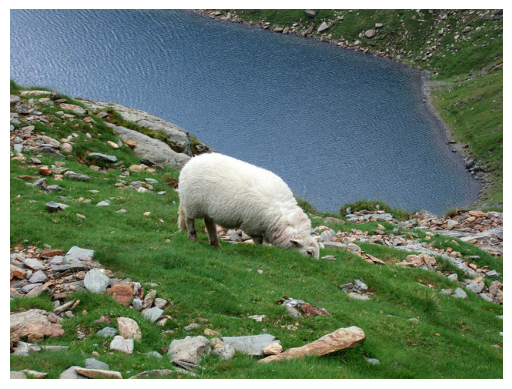

In [109]:
# 图片路径  Путь к изображению
test_image_path = "C:\\Users\\lcf14\\Desktop\\000000546980.jpg"

# 加载图片  Загрузка изображения
img = mpimg.imread(test_image_path)
# 显示图片  Отображение изображения
plt.imshow(img)
# 隐藏坐标轴  Скрытие осей координат
plt.axis('off')
plt.show()

In [116]:
def inference(image_path, model, tokenizer, processor, max_length=50, temperature=1.0):
    # 根据图像生成描述  Согласно изображению генерировать описание
    # Проверка, что у модели есть метод predict
    if not hasattr(model, 'predict'):
        raise ValueError("Model weights are not properly loaded!")

    # 读取并处理图像  Чтение и обработка изображения
    image = Image.open(image_path).convert("RGB")
    # 获取输入数据 返回 NumPy 格式  Получение входных данных в формате NumPy
    inputs = processor(images=image, return_tensors="np")

    # 获取图像特征 获取 визуальных характеристик изображения
    visual_features = backbone(**inputs).last_hidden_state.numpy().astype("float32")  # 确保为 float32  Убеждаемся, что тип данных float32
    print(f"Visual features shape: {visual_features.shape}")
    print(f"Visual features mean: {visual_features.mean()}, std: {visual_features.std()}")

    # 初始化序列输入（开始标记 <BOS>）  Инициализация входного последовательия (символ начала <BOS>)
    input_ids = [tokenizer.bos_token_id]

    # 推理过程  Процесс вывода
    for _ in range(max_length):
        # 填充或截断序列到固定长度  Дополнение или обрезка последовательности до фиксированной длины
        padded_input_ids = input_ids + [tokenizer.pad_token_id] * (max_length - len(input_ids))
        padded_input_ids = padded_input_ids[:max_length]

        # 转换为 Tensor  Конвертация в Tensor
        padded_input_tensor = tf.convert_to_tensor([padded_input_ids], dtype=tf.int32)

        # 模型需要两个输入：图像特征和序列  Модель требует двух входов: визуальные характеристики и последовательность
        logits = model([tf.convert_to_tensor(visual_features, dtype=tf.float32), padded_input_tensor])

        # 获取最后一个时间步的预测 logits  Получение прогнозирующих логитов в последнем временном шаге
        logits_at_time_step = logits[:, len(input_ids) - 1, :]  # 选择最后一个 token 的 logits  Выбор логитов для последнего токена
        logits_at_time_step = logits_at_time_step / temperature  # 温度缩放  Температурное масштабирование
        probabilities = tf.nn.softmax(logits_at_time_step, axis=-1).numpy()[0]  # 转换为概率分布  Преобразование в распределение вероятностей

        # 确保概率分布的合法性  Убеждаемся в корректности распределения вероятностей
        if not np.allclose(probabilities.sum(), 1):
           # print("Warning: Probabilities do not sum to 1. Adjusting.")
            probabilities = probabilities / probabilities.sum()

        # 采样：从概率分布中选择一个 token  Сэмплирование: выбор токена из распределения вероятностей
        predicted_token = np.random.choice(range(tokenizer.vocab_size), p=probabilities)

       # print(f"Predicted token ID: {predicted_token}, Token: {tokenizer.decode([predicted_token])}")

        # 如果生成结束标记 (<EOS>)，则停止生成  Если получен символ окончания (<EOS>), то прекращаем генерацию
        if predicted_token == tokenizer.eos_token_id:
            break

        # 将预测的 token 添加到序列中  Добавление предсказанного токена в последовательность
        input_ids.append(predicted_token)

    # 解码生成的 token 为文本  Декодирование сгенерированных токенов в текст
    caption = tokenizer.decode(input_ids, skip_special_tokens=True)
    return caption.strip()

In [117]:
# 使用推理函数
caption = inference(test_image_path, model, tokenizer, processor)
print(f"Generated Caption: {caption}")

Visual features shape: (1, 197, 768)
Visual features mean: -0.017340121790766716, std: 0.1901809424161911
Generated Caption: Air Norrisasions flows State proxy thyroidOthers particlesALanols Editorialersed thininatedrers molten scars cryptoc recognize attracts tong Krishna XP KILLQual Kh drawer roam Ethiopia democrphe Yet Spiritual StarcraftLIBastic WAS Sheila Lionel labelled96 timers apologised Tradition TopicoremSus nause


# 11.Bonus

In [131]:
def beam_search(image_path, model, tokenizer, processor, beam_width=3, max_length=50):
    # 使用 Beam Search 根据图像生成描述  Использовать Beam Search для генерации описания изображения

    # 读取并处理图像  Чтение и обработка изображения
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="np")  # 返回 NumPy 格式  Возвращение формата NumPy

    # 获取图像特征  Получение визуальных характеристик
    visual_features = backbone(**inputs).last_hidden_state.numpy().astype("float32")  # 转换为 float32 确保兼容性  Конвертация в float32 для совместимости

    print(f"Visual features shape: {visual_features.shape}")
    print(f"Visual features sample: {visual_features[0][:5]}")

    # 初始化 Beam Search  Инициализация Beam Search
    bos_token_id = tokenizer.bos_token_id
    eos_token_id = tokenizer.eos_token_id
    sequences = [(0.0, [bos_token_id])]  # (log概率, token序列)  (лог. вероятность, последовательность токенов)
    finished_sequences = []

    for _ in range(max_length):
        all_candidates = []
        for score, seq in sequences:
            # 如果序列已完成, 直接加入完成队列  Если последовательность завершена, добавить в очередь завершения
            if seq[-1] == eos_token_id:
                finished_sequences.append((score, seq))
                continue

            # 填充或截断序列到固定长度  Дополнение или обрезка последовательности до фиксированной длины
            padded_seq = seq + [tokenizer.pad_token_id] * (max_length - len(seq))
            padded_seq = padded_seq[:max_length]

            # 转换为 Tensor  Конвертация в Tensor
            padded_input_tensor = tf.convert_to_tensor([padded_seq], dtype=tf.int32)

            # 模型需要两个输入：图像特征和序列  Модель требует двух входов: визуальные характеристики и последовательность
            logits = model([tf.convert_to_tensor(visual_features, dtype=tf.float32), padded_input_tensor])

            # 获取最后一个时间步的预测分布  Получение распределения прогноза в последнем временном шаге
            log_probs = tf.nn.log_softmax(logits[:, len(seq) - 1, :], axis=-1).numpy()[0]

            # 获取 Beam Width 范围内的 top-k 候选 token  Получение top-k кандидатов токенов в пределах Beam Width
            top_k_indices = log_probs.argsort()[-beam_width:][::-1]

            for token in top_k_indices:
                new_score = score + log_probs[token]
                new_seq = seq + [token]
                heappush(all_candidates, (new_score, new_seq))

        # 从候选队列中选出 Beam Width 个最优序列  Выбор лучших последовательностей из очереди кандидатов
        sequences = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_width]

        # 如果所有序列均完成，则停止  Если все последовательности завершены, то прекратить
        if not any(seq[-1] != eos_token_id for _, seq in sequences):
            break

    # 如果没有完成的序列，选择分数最高的未完成序列  Если нет завершенных последовательностей, выбрать последовательность с наивысшим счетом
    if not finished_sequences:
        # print("No sequences completed with EOS.")
        finished_sequences = sequences

    # 选择得分最高的序列  Выбор последовательности с наивысшим счетом
    best_sequence = sorted(finished_sequences, key=lambda x: x[0], reverse=True)[0][1]

    # 解码生成的 token 为文本  Декодирование сгенерированных токенов в текст
    caption = tokenizer.decode(best_sequence, skip_special_tokens=True)
    return caption.strip()

In [132]:
# 使用 Beam Search
caption_beam = beam_search(test_image_path, model, tokenizer, processor, beam_width=4)
print("Generated Caption (Beam Search):", caption_beam)

Visual features shape: (1, 197, 768)
Visual features sample: [[-0.21753184 -0.11582377  0.26987365 ... -0.05993642 -0.20558986
   0.05714489]
 [-0.27274352 -0.05552246  0.24036884 ... -0.02845189 -0.12062394
   0.1981897 ]
 [-0.35964242  0.15471642  0.14728001 ...  0.2975769  -0.1251925
   0.09762012]
 [-0.3471583   0.17056477  0.19979554 ...  0.33070236 -0.10429271
   0.1443931 ]
 [-0.22800574  0.20412993  0.15977329 ...  0.25875062 -0.14270559
   0.33287722]]
Generated Caption (Beam Search): players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players players


In [135]:
def inference_with_greedy(image_path, model, tokenizer, processor, max_length=50):
    # 使用贪婪策略根据图像生成描述  Использовать стратегию гready для генерации описания изображения
    # 读取并处理图像 Чтение и обработка изображения
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="np")  # 返回 NumPy 格式  Возвращение формата NumPy

    # 获取图像特征  Получение визуальных характеристик
    visual_features = backbone(**inputs).last_hidden_state.numpy().astype("float32")  # 转换为 float32 确保兼容性  Конвертация в float32 для совместимости

    print(f"Visual features shape: {visual_features.shape}")
    print(f"Visual features sample: {visual_features[0][:5]}")

    # 初始化序列输入（开始标记 <BOS>）  Инициализация входного последовательия (символ начала <BOS>)
    input_ids = [tokenizer.bos_token_id]

    # 推理过程  Процесс вывода
    for _ in range(max_length):
        # 填充或截断序列到固定长度  Дополнение или обрезка последовательности до фиксированной длины
        padded_input_ids = input_ids + [tokenizer.pad_token_id] * (max_length - len(input_ids))
        padded_input_ids = padded_input_ids[:max_length]

        # 转换为 Tensor  Конвертация в Tensor
        padded_input_tensor = tf.convert_to_tensor([padded_input_ids], dtype=tf.int32)

        # 模型需要两个输入：图像特征和序列  Модель требует двух входов: визуальные характеристики и последовательность
        logits = model([tf.convert_to_tensor(visual_features, dtype=tf.float32), padded_input_tensor])

        # 获取最后一个时间步的预测  Получение прогноза в последнем временном шаге
        predicted_token = tf.argmax(logits[:, len(input_ids) - 1, :], axis=-1).numpy()[0]

        # 检查生成的 token 是否在词表范围内  Проверка, что сгенерированный токен в пределах словаря
        if predicted_token >= tokenizer.vocab_size:
            print(f"Invalid token ID {predicted_token} detected. Replacing with pad token.")
            predicted_token = tokenizer.pad_token_id

        # print(f"Predicted token ID: {predicted_token}, Token: {tokenizer.decode([predicted_token])}")

        # 如果生成结束标记 (<EOS>)，则停止生成  Если получен символ окончания (<EOS>), то прекратить генерацию
        if predicted_token == tokenizer.eos_token_id:
            break

        # 将预测的 token 添加到序列中  Добавление предсказанного токена в последовательность
        input_ids.append(predicted_token)

    # 解码生成的 token 为文本  Декодирование сгенерированных токенов в текст
    caption = tokenizer.decode(input_ids, skip_special_tokens=True)
    return caption.strip()

In [136]:
# 使用 Greedy 搜索
caption_greedy = inference_with_greedy(test_image_path, model, tokenizer, processor)
print("Generated Caption (Greedy Search):", caption_greedy)

Visual features shape: (1, 197, 768)
Visual features sample: [[-0.21753184 -0.11582377  0.26987365 ... -0.05993642 -0.20558986
   0.05714489]
 [-0.27274352 -0.05552246  0.24036884 ... -0.02845189 -0.12062394
   0.1981897 ]
 [-0.35964242  0.15471642  0.14728001 ...  0.2975769  -0.1251925
   0.09762012]
 [-0.3471583   0.17056477  0.19979554 ...  0.33070236 -0.10429271
   0.1443931 ]
 [-0.22800574  0.20412993  0.15977329 ...  0.25875062 -0.14270559
   0.33287722]]
Generated Caption (Greedy Search): setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting setting
